In [1]:
from LIMxCMBL.init import *

In [2]:
eHIeHI = np.zeros((len(chibs), len(chibs)), dtype=np.float64)

In [3]:
zmin = 2.0
zmax = 2.5
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

In [4]:
L = chimax - chimin

In [5]:
dchi = L / 10

In [6]:
eIeI = np.zeros_like(eHIeHI)

In [7]:
for chi_idx in range(len(chibs)):
    chi = chibs[chi_idx]
    if(chi > chimin and chi < chimax):
        #(2 pi) delta^{(D)}(chi - chi') -- discrete -> (2pi) / dchi
        eIeI[chi_idx, chi_idx] = 1 / (dchi * chi**2) 

In [8]:
Lambda = 0.01 # 1 / cMpc, usual cut for HI

In [9]:
eIeLO = np.zeros_like(eHIeHI)
for chi_idx in range(len(chibs)):
    chi = chibs[chi_idx]
    if(chi > chimin and chi < chimax):
        for chip_idx in range(len(chibs)):
            chip = chibs[chip_idx]
            eIeLO[chi_idx, chip_idx] = 1/chi**2 * Lambda/np.pi * np.sinc(Lambda * (chi - chip))

In [10]:
eLOeI = np.zeros_like(eHIeHI)
for chi_idx in range(len(chibs)):
    chi = chibs[chi_idx]
    for chip_idx in range(len(chibs)):
        chip = chibs[chip_idx]
        if(chip > chimin and chip < chimax):
            eLOeI[chi_idx, chip_idx] = 1/chip**2 * Lambda/np.pi * np.sinc(Lambda * (chip - chi))

In [11]:
def KepsLO(chip, chi):
    return np.sinc(Lambda * (chi - chip)) * Lambda / np.pi

In [12]:
from scipy.integrate import quad, quad_vec

In [13]:
from tqdm import trange

In [14]:
np.inf

inf

In [15]:
print(type(chibs))
print(chibs.flags)  # This will show the array's properties


<class 'numpy.ndarray'>
  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



In [16]:
eLOeLO = np.zeros_like(eHIeHI)
def integrand(chib, chi, chibs):
    return 1/chib**2 * KepsLO(chib, chi) * KepsLO(chib, chibs)

for chi_idx in trange(len(chibs)):
    chi = chibs[chi_idx]
    
    current_integrand = lambda x: integrand(x, chi, chibs)

        
    eLOeLO[chi_idx], _ = quad_vec(current_integrand, 
                                     chimin, chimax,
                                     epsabs = 0.0, 
                                     epsrel = 1e-3)

100%|██████████| 256/256 [00:01<00:00, 223.50it/s]


In [17]:
print(type(chibs))
print(chibs.flags)  # This will show the array's properties


<class 'numpy.ndarray'>
  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



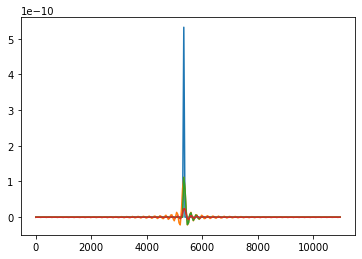

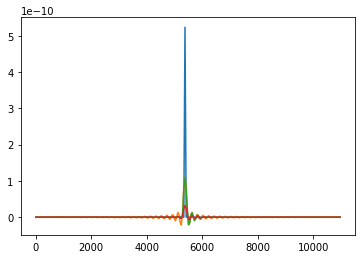

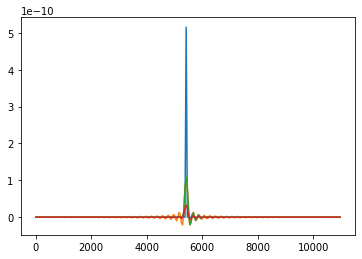

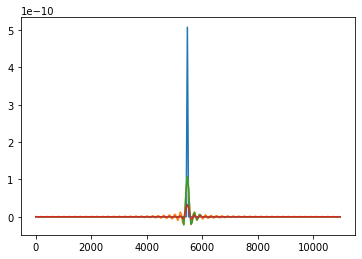

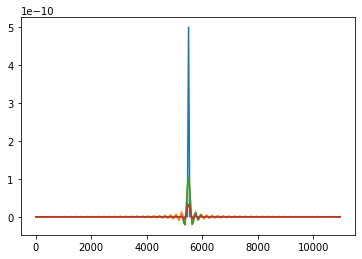

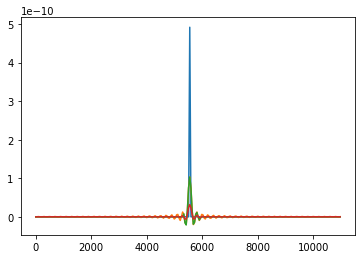

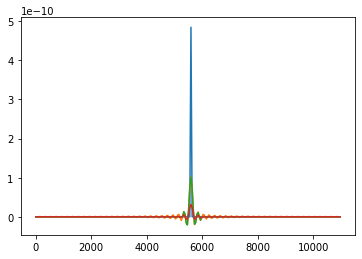

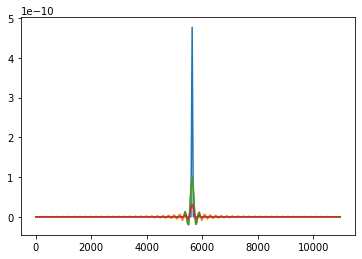

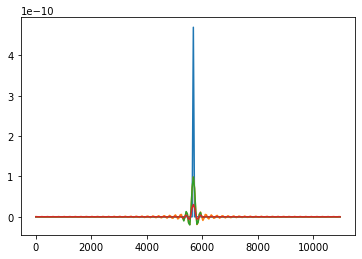

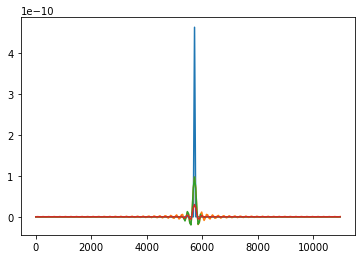

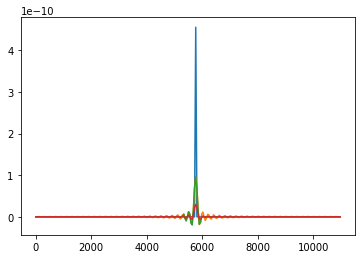

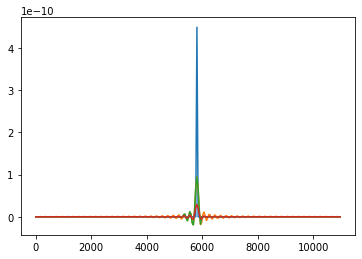

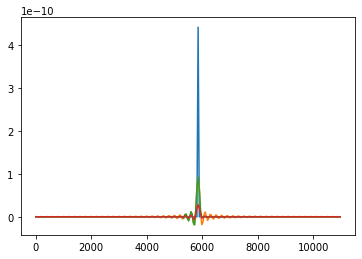

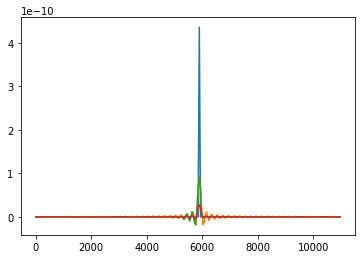

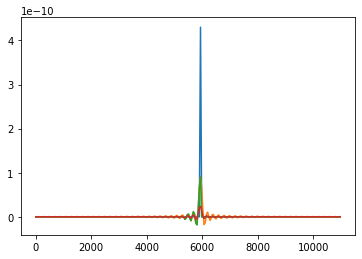

In [18]:
for chi_idx in range(len(chibs)):
    if(chibs[chi_idx] > chimax or chibs[chi_idx]< chimin):
        continue
    plt.plot(chibs, eIeI[chi_idx])
    plt.plot(chibs, eIeLO[chi_idx])
    plt.plot(chibs, eLOeI[chi_idx])
    plt.plot(chibs, eLOeLO[chi_idx])

    plt.show()

In [19]:
eHIeHI = eIeI + eLOeLO - eIeLO - eLOeI

In [20]:
from matplotlib import colors

In [21]:
chimin

5319.735377755262

In [22]:
chimax

5978.911518337892

In [23]:
plt.show()
plt.rcParams['text.usetex'] = True

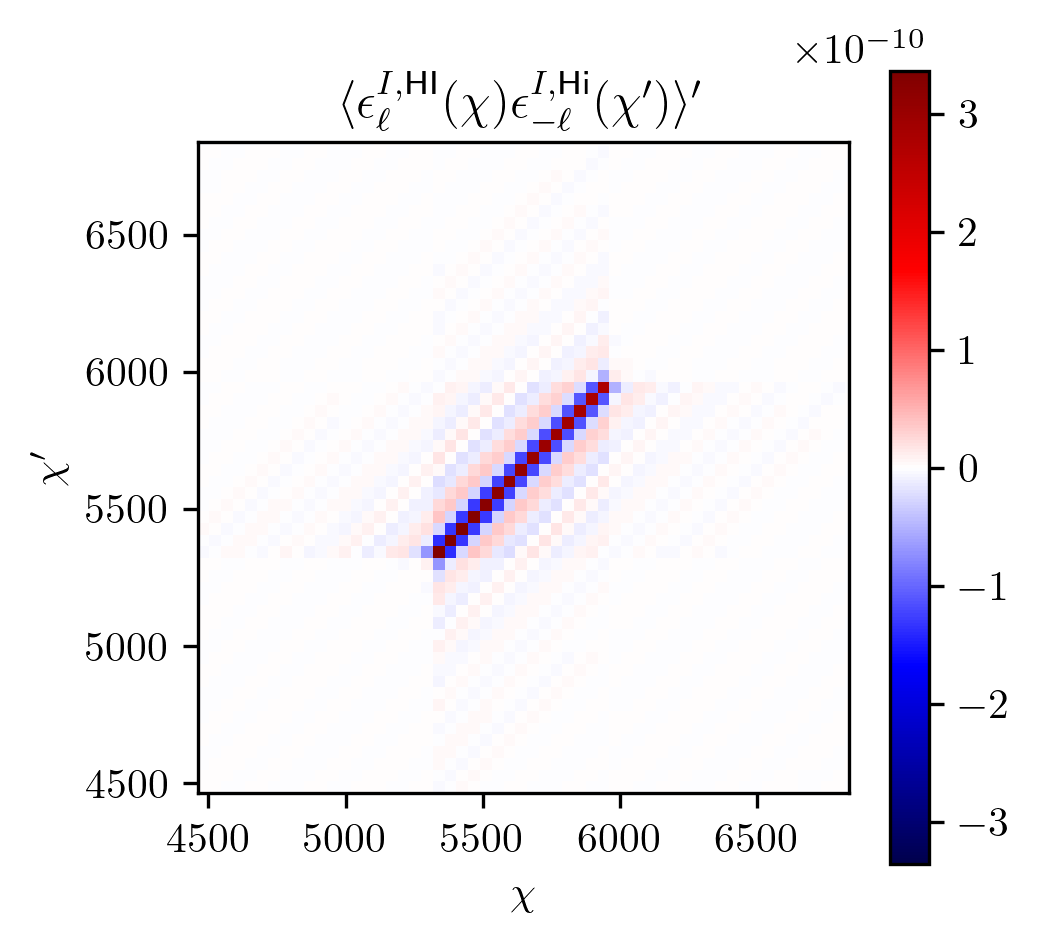

In [24]:
vminmax = np.max(np.abs(eHIeHI))
plt.figure(figsize=(3.5,3.5), dpi=300, facecolor='w',)

# figure out bounds
plot_window = 1.3*(chimax - chimin)
left_chi = chimin - plot_window
right_chi = chimax + plot_window
 
# plot data
plt.imshow(eHIeHI, 
           origin='lower',
          cmap = 'seismic',
          vmin = -vminmax,
          vmax =  vminmax,
          extent=[chibs[0], chibs[-1], chibs[0], chibs[-1]])

plt.colorbar()
# set bounds
plt.xlim(left_chi, right_chi)
plt.ylim(left_chi, right_chi)

plt.xlabel(r'$\chi$')
plt.ylabel(r"$\chi'$")
plt.title(r"$\langle \epsilon^{I,{\sf HI}}_\ell(\chi) \epsilon^{I, {\sf Hi}}_{-\ell}(\chi')\rangle'$")
plt.savefig('figures/004.000.eHIeHI.pdf', bbox_inches='tight')

In [25]:
def tmp_plot(field):
    vminmax = np.max(np.abs(field))
    plt.figure(figsize=(3.5,3.5), dpi=100, facecolor='w',)

    # figure out bounds
    plot_window = 1.3*(chimax - chimin)
    left_chi = chimin - plot_window
    right_chi = chimax + plot_window

    # plot data
    plt.imshow(field, 
               origin='lower',
              cmap = 'seismic',
              vmin = -vminmax,
              vmax =  vminmax,
              extent=[chibs[0], chibs[-1], chibs[0], chibs[-1]])

    plt.colorbar()
    # set bounds
    plt.xlim(left_chi, right_chi)
    plt.ylim(left_chi, right_chi)

    plt.xlabel(r'$\chi$')
    plt.ylabel(r"$\chi'$")


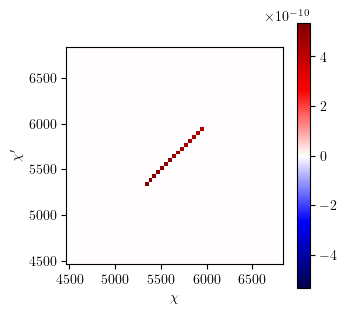

In [26]:
tmp_plot(eIeI)

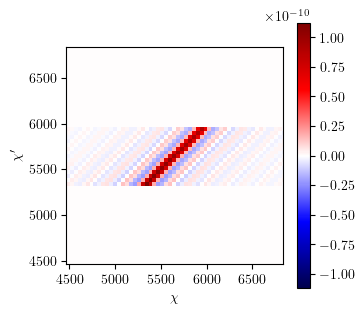

In [27]:
tmp_plot(eIeLO)

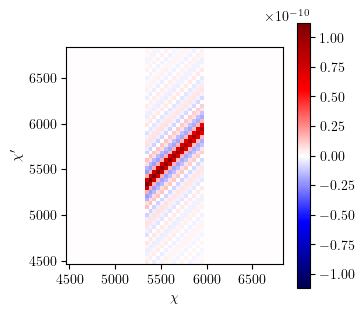

In [28]:
tmp_plot(eLOeI)

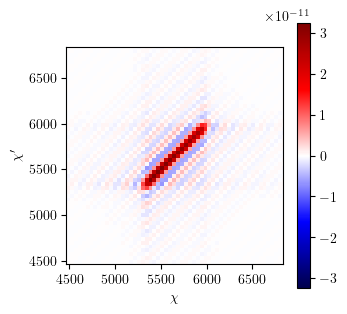

In [29]:
tmp_plot(eLOeLO)

In [30]:
from LIMxCMBL.noise import *

In [31]:
tmp_eHIeHI = get_eHIeHI(1, chimin, chimax, dchi, Lambda)

computing eIeI
computing eIeLO
computing eLOeI
computing eLOeLO


100%|██████████| 256/256 [00:01<00:00, 223.29it/s]


In [34]:
np.allclose(tmp_eHIeHI, eHIeHI, rtol=1e-08, atol=0.0)

True